In [1]:
import numpy as np
import pandas as pd

C:\Users\tridi\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df=pd.read_csv('sf.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-31,130.800003,137.850006,129.050003,136.649994,136.649994,959654
1,2023-02-01,137.350006,143.500000,130.050003,134.250000,134.250000,1686843
2,2023-02-02,134.000000,137.899994,132.750000,133.949997,133.949997,777034
3,2023-02-03,134.550003,136.149994,126.050003,132.149994,132.149994,1290369
4,2023-02-06,132.149994,134.800003,129.800003,132.100006,132.100006,483143


In [3]:
print(df.head(1)['Date'])
print(df.tail(1)['Date'])

0    2023-01-31
Name: Date, dtype: object
245    2024-01-30
Name: Date, dtype: object


In [4]:
df.shape

(246, 7)

In [5]:
x=df['Date'].iloc[-1]
x

'2024-01-30'

In [6]:
#function to increase date by 1

from datetime import datetime, timedelta

def increase(date_string):
    date_obj = datetime.strptime(date_string, "%Y-%m-%d")
    new_date_obj = date_obj + timedelta(days=1)
    formatted_date = datetime.strftime(new_date_obj, "%Y-%m-%d")

    return formatted_date 

In [7]:
start_date=df['Date'][0]
new_df=pd.DataFrame()
end_date=x
date_index = pd.date_range(start=start_date, end=end_date, freq='D')
new_df['Date']=date_index
df['Date'] = pd.to_datetime(df['Date'])
merged_df = pd.merge(df,new_df, on='Date', how='right')
merged_df=merged_df.interpolate(method='ffill',limit_direction='forward')

In [8]:
merged_df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
data=pd.DataFrame()
data['Date']=merged_df['Date']
data['Close']=merged_df['Close']
data

,Date,Close
0,2023-01-31,136.649994
1,2023-02-01,134.250000
2,2023-02-02,133.949997
3,2023-02-03,132.149994
4,2023-02-04,132.149994
...,...,...
360,2024-01-26,233.350006
361,2024-01-27,233.350006
362,2024-01-28,233.350006
363,2024-01-29,227.449997


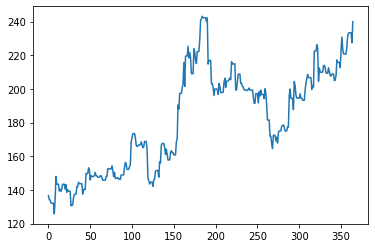

In [10]:
import matplotlib.pyplot as plt

plt.plot(data['Close'])

In [11]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

x=data['Close'].values
result=adfuller(x)
print('ADF Statistics = %f' %result[0])
print('p value = %f' %result[1])
print('Critical Values : ')
for x,y in result[4].items():
    print('\t %s : %f' %(x,y))
    
    
def test(index):
    x=data[index].values
    result=adfuller(x)
    if(result[1] >0.05 and result[0]>result[4]['1%'] and result[0]>result[4]['5%'] and result[0]>result[4]['10%']):
        print('Data is NON STATIONARY')
    else:
        print('Data is STATIONARY')

test('Close')

ADF Statistics = -1.163488
p value = 0.689102
Critical Values : 
	 1% : -3.448494
	 5% : -2.869535
	 10% : -2.571029
Data is NON STATIONARY


In [12]:
data['Value']=data['Close'].diff()
x=data['Value'].mean()
data['Value']=data['Value'].fillna(x)

In [13]:
test('Value')

Data is STATIONARY


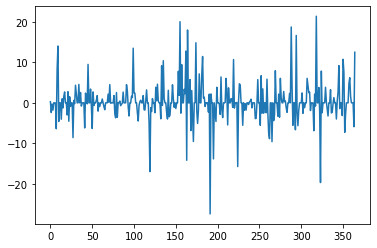

In [14]:
plt.plot(data['Value'])

In [15]:
df=pd.DataFrame()

df['Date']=data['Date']
df['Original']=data['Close']
df['Value']=data['Value']

In [16]:
df

,Date,Original,Value
0,2023-01-31,136.649994,0.283791
1,2023-02-01,134.250000,-2.399994
2,2023-02-02,133.949997,-0.300003
3,2023-02-03,132.149994,-1.800003
4,2023-02-04,132.149994,0.000000
...,...,...,...
360,2024-01-26,233.350006,0.000000
361,2024-01-27,233.350006,0.000000
362,2024-01-28,233.350006,0.000000
363,2024-01-29,227.449997,-5.900009


In [17]:
df1=pd.DataFrame()
df2=pd.DataFrame()

df1['Date']=df['Date']
df1['Original']=df['Original']
df1['Value']=df['Value']

df2['Date']=df['Date']
df2['Original']=df['Original']
df2['Value']=df['Value']

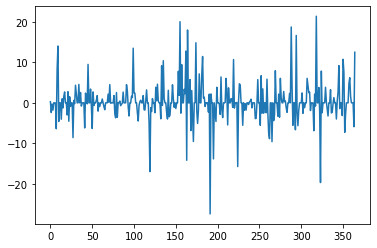

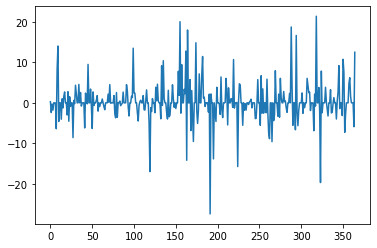

In [18]:
plt.plot(df1['Value'])
plt.show()
plt.plot(df2['Value'])
plt.show()

In [19]:
# LSTM

In [20]:
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from numpy import array
from keras.models import Sequential
from keras.layers import Dense,Flatten
from tensorflow.python.keras.layers import LSTM
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from datetime import datetime, timedelta

In [21]:
scaler = MinMaxScaler()
#df1['Value']=scaler.fit_transform(df1[['Value']])

def split_sequence(sequence,steps):
    x,y=list(),list()
    for start in range(len(sequence)):
        end_index=start+steps
        if end_index > len(sequence)-1:
            break;
        sequence_x,sequence_y=sequence[start:end_index],sequence[end_index]
        x.append(sequence_x)
        y.append(sequence_y)
    return array(x),array(y)

d=df1['Value'].tolist()

steps=6 
x,y=split_sequence(d,steps)

features=1
x=x.reshape((x.shape[0],x.shape[1],features))

#Build LSTM model
model_lstm=Sequential()
#Add first layer to model
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(x.shape[1],1)))
#Add second layer to model
model_lstm.add(LSTM(50, return_sequences=False))
#Add Dense Layer to model with 25 neurons
model_lstm.add(Dense(25))
#Add Dense Layer to model with 1 neuron
model_lstm.add(Dense(1))

model_lstm.compile(loss='mean_squared_error',optimizer='adam')

model_lstm.fit(x,y,epochs=500,verbose=0)

test_data_x= x[-50:]
test_data_y= y[-50:]

test_data_pred=model_lstm.predict(test_data_x)

mean = np.mean(test_data_pred)
abs_deviations = np.abs(test_data_pred-mean)
mad = np.mean(abs_deviations)
print("MAD:", mad)

mse = mean_squared_error(test_data_y,test_data_pred)
rmse = np.sqrt(mse)
print("RMSE :",rmse)


def mean_absolute_percentage_error(y_actual, y_predicted):
    return np.mean(np.abs((y_actual-y_predicted)/y_actual))*100

mape = mean_absolute_percentage_error(np.array(test_data_y), np.array(test_data_pred))
print("MAPE:", mape)


def mean_bias_error(y_actual, y_predicted):
    return mean_squared_error(y_actual,y_predicted)

mbe = mean_bias_error(np.array(test_data_y), np.array(test_data_pred))
print("MSE:", mbe)

print(r2_score(test_data_y,test_data_pred))

2/2 [==============================] - 1s 4ms/step
MAD: 3.5425477
RMSE : 0.3536000209451938
MAPE: inf
MSE: 0.12503297481244152
0.9961488530333306


<ipython-input-21-60bb7c2850a8>:54: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_actual-y_predicted)/y_actual))*100


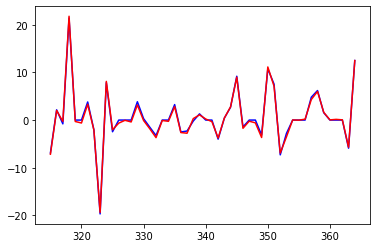

In [22]:
plt.plot(df.tail(50).index, test_data_y, color='blue')
plt.plot(df.tail(50).index, test_data_pred, color='red')
plt.show()

1/1 [==============================] - 0s 17ms/step


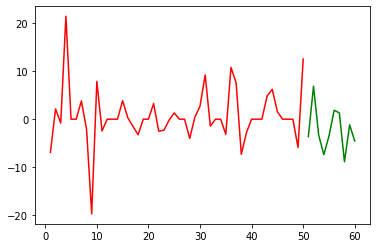

In [23]:
def increase(date_string):
    date_obj = datetime.strptime(date_string, "%Y-%m-%d")
    new_date_obj = date_obj + timedelta(days=1)
    formatted_date = datetime.strftime(new_date_obj, "%Y-%m-%d")
    return formatted_date 

data=df1['Value'].tolist()
forecasted_df=pd.DataFrame(columns=['Date','Value'])
start_date='2024-02-01'


for i in range(10):
    new_date=increase(start_date)
    forecast_input=array(data[-6:])
    x_forecast=forecast_input.reshape(1,steps,features)
    forecasted_y=model_lstm.predict(x_forecast).item()
    forecasted_df.at[i,'Date']=new_date
    forecasted_df.at[i,'Value']=forecasted_y
    data.append(forecasted_y)
    start_date=new_date
    
index_old=np.arange(1,51)
index_new=np.arange(51,61)

plt.plot(index_old, test_data_y, color='red')
plt.plot(index_new,forecasted_df['Value'], color='green')

In [24]:
forecasted_df['Value']

0   -3.625479
1    6.843431
2   -3.308863
3   -7.380751
4   -3.508637
5    1.839751
6    1.323176
7   -8.860006
8   -1.186578
9   -4.546895
Name: Value, dtype: object

In [25]:
forcasted_dif=forecasted_df['Value']

In [26]:
forcasted_dif

0   -3.625479
1    6.843431
2   -3.308863
3   -7.380751
4   -3.508637
5    1.839751
6    1.323176
7   -8.860006
8   -1.186578
9   -4.546895
Name: Value, dtype: object

In [27]:
dif_list=np.array(forcasted_dif).flatten().tolist()

In [28]:
dif_list

[-3.625479221343994,
 6.84343147277832,
 -3.308863401412964,
 -7.380751132965088,
 -3.5086374282836914,
 1.839751124382019,
 1.3231755495071411,
 -8.860006332397461,
 -1.1865780353546143,
 -4.546894550323486]

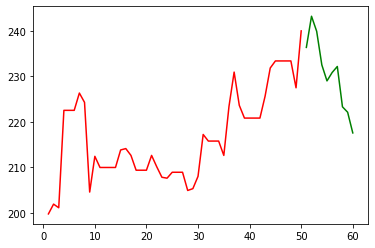

In [29]:
last_value=df1.tail(1)['Original'].iloc[0]

forecasted_og=[]

for i in range(len(dif_list)):
    n=last_value+dif_list[i]
    forecasted_og.append(n)
    last_value=n
    
forecasted_df['Retrive']=forecasted_og

index_old=np.arange(1,51)
index_new=np.arange(51,61)

last_300 = df['Original'][-50:].tolist()

plt.plot(index_old, last_300, color='red')
plt.plot(index_new,forecasted_df['Retrive'], color='green')

In [30]:
last_value

217.53914504458618

In [31]:
forecasted_df['Retrive']

0    236.324518
1    243.167949
2    239.859086
3    232.478335
4    228.969697
5    230.809448
6    232.132624
7    223.272618
8    222.086040
9    217.539145
Name: Retrive, dtype: float64

In [32]:
lstm_list=forecasted_df['Retrive']

In [33]:
#random forest regression

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [35]:
scaler = MinMaxScaler()
df2['Value']=scaler.fit_transform(df2[['Value']])

def split_sequence(sequence,steps):
    x,y=list(),list()
    for start in range(len(sequence)):
        end_index=start+steps
        if end_index > len(sequence)-1:
            break;
        sequence_x,sequence_y=sequence[start:end_index],sequence[end_index]
        x.append(sequence_x)
        y.append(sequence_y)
    return array(x),array(y)

d=df2['Value'].tolist()

steps=6 

n=100
ans=0
max_acc=0

while(n<=2000):
    x,y=split_sequence(d,steps)
    model=RandomForestRegressor(n_estimators=n, random_state = 42)
    model.fit(x,y)
    test_data_x= x[-50:]
    test_data_y= y[-50:]
    test_data_pred=model.predict(test_data_x)
    acc=r2_score(test_data_y,test_data_pred)
    if(acc>max_acc):
        max_acc=acc
        ans=n
    n=n+100
    
print(ans)

model=RandomForestRegressor(n_estimators =ans, random_state = 42)
model.fit(x,y)

test_data_x= x[-50:]
test_data_y= y[-50:]

test_data_pred=model.predict(test_data_x)

mean = np.mean(test_data_pred)
abs_deviations = np.abs(test_data_pred-mean)
mad = np.mean(abs_deviations)
print("MAD:", mad)

mse = mean_squared_error(test_data_y,test_data_pred)
rmse = np.sqrt(mse)
print("RMSE :",rmse)


def mean_absolute_percentage_error(y_actual, y_predicted):
    return np.mean(np.abs((y_actual-y_predicted)/y_actual))*100

mape = mean_absolute_percentage_error(np.array(test_data_y), np.array(test_data_pred))
print("MAPE:", mape)


def mean_bias_error(y_actual, y_predicted):
    return mean_squared_error(y_actual,y_predicted)

mbe = mean_bias_error(np.array(test_data_y), np.array(test_data_pred))
print("MSE:", mbe)

print(r2_score(test_data_y,test_data_pred))

700
MAD: 0.049353437438322795
RMSE : 0.04270755983946898
MAPE: 5.697667790255708
MSE: 0.0018239356674418237
0.8659385166313118


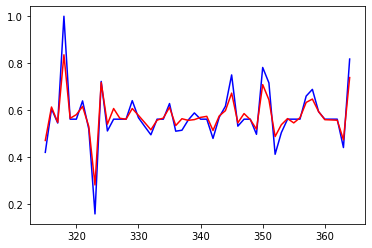

In [36]:
plt.plot(df.tail(50).index, test_data_y, color='blue')
plt.plot(df.tail(50).index, test_data_pred, color='red')
plt.show()

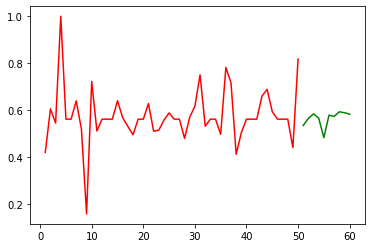

In [37]:
def increase(date_string):
    date_obj = datetime.strptime(date_string, "%Y-%m-%d")
    new_date_obj = date_obj + timedelta(days=1)
    formatted_date = datetime.strftime(new_date_obj, "%Y-%m-%d")
    return formatted_date 

data=df2['Value'].tolist()
forecasted_df=pd.DataFrame(columns=['Date','Value'])
start_date='2024-02-01'

for i in range(10):
    new_date=increase(start_date)
    forecast_input=array(data[-6:])
    #x_forecast=forecast_input.reshape(1,steps,features) #lstm
    x_forecast=forecast_input.reshape(1,-1)
    forecasted_y=model.predict(x_forecast).item()
    forecasted_df.at[i,'Date']=new_date
    forecasted_df.at[i,'Value']=forecasted_y
    data.append(forecasted_y)
    start_date=new_date
    
index_old=np.arange(1,51)
index_new=np.arange(51,61)

plt.plot(index_old, test_data_y, color='red')
plt.plot(index_new,forecasted_df['Value'], color='green')

In [38]:
#forcasted_dif=forecasted_df['Value']
forcasted_dif=scaler.inverse_transform(np.array(forecasted_df['Value']).reshape(-1,1))

In [39]:
forecasted_df['Value']

0    0.535249
1    0.565328
2    0.584489
3    0.566095
4    0.483367
5    0.579034
6    0.573911
7    0.593243
8    0.589349
9    0.583328
Name: Value, dtype: object

In [40]:
dif_list=np.array(forcasted_dif).flatten().tolist()

In [41]:
dif_list

[-1.303069148571383,
 0.16628536285717357,
 1.1022865585714094,
 0.20371435857143216,
 -3.8375004071428456,
 0.8357863828571974,
 0.5855708200000872,
 1.5299292528572475,
 1.339715790000024,
 1.0455719985713574]

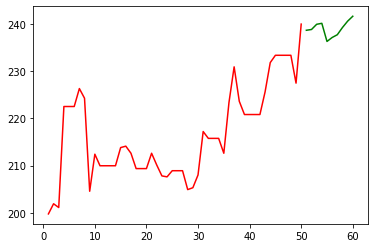

In [42]:
last_value=df.tail(1)['Original'].iloc[0]

forecasted_og=[]

for i in range(len(dif_list)):
    n=last_value+dif_list[i]
    forecasted_og.append(n)
    last_value=n
    
forecasted_df['Retrive']=forecasted_og

index_old=np.arange(1,51)
index_new=np.arange(51,61)

last_300 = df['Original'][-50:].tolist()

plt.plot(index_old, last_300, color='red')
plt.plot(index_new,forecasted_df['Retrive'], color='green')

In [43]:
last_value

241.6182879685717

In [44]:
forecasted_df['Retrive']

0    238.646928
1    238.813213
2    239.915500
3    240.119214
4    236.281714
5    237.117500
6    237.703071
7    239.233000
8    240.572716
9    241.618288
Name: Retrive, dtype: float64

In [45]:
rfr_list=forecasted_df['Retrive']

In [46]:
rfr_list

0    238.646928
1    238.813213
2    239.915500
3    240.119214
4    236.281714
5    237.117500
6    237.703071
7    239.233000
8    240.572716
9    241.618288
Name: Retrive, dtype: float64

In [48]:
result=[]

for i in range(len(rfr_list)):
    result.append(lstm_list[i]*0.6 + rfr_list[i]*0.4)
    
result

[237.25348180776504,
 241.4260548365749,
 239.8816514191557,
 235.53468648280523,
 231.89450386297787,
 233.33266909074996,
 234.3608027484543,
 229.6567706501587,
 229.48071014494596,
 227.17080221418038]

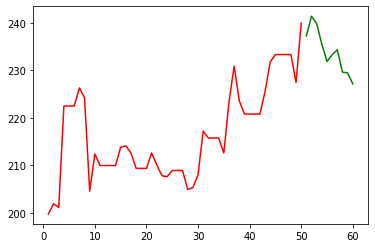

In [49]:
index_old=np.arange(1,51)
index_new=np.arange(51,61)

last_300 = df['Original'][-50:].tolist()

plt.plot(index_old, last_300, color='red')
plt.plot(index_new,result, color='green')